<a href="https://colab.research.google.com/github/SuheirJammal/Adult_Income_Prediction_Analysis/blob/main/Adult_Income_Analysis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing and Snippets

In [ ]:
#mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import basic libraries
import pandas as pd
import numpy as np
#to remove warnings
import warnings

In [ ]:
#import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [492]:
#import modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.pipeline import make_pipeline as make_sampler_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn import set_config
set_config(transform_output='pandas')

from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

## Customised Visualization Functions

## Customized Evaluation Metrics

In [ ]:
def classification_metrics(y_true, y_pred, label= '', output_dict=False, figsize = (8,4), normalize='true', cmap = 'Blues', colorbar = False):

  header = '-' * 70

  #get the classification report as a string
  report = classification_report(y_true, y_pred)

  #print the header and report
  print(header, f"Classification Metrics: {label}", header, sep="\n")
  print (report)


  #print heatmaps of the confusion matrices
  fig, ax = plt.subplots(ncols=2, figsize=figsize)

  #create a confusion matrix with raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax = ax[0], normalize=None, cmap='gist_gray', colorbar= colorbar)
  ax[0].set_title('Raw Counts')

  #create a confusion matrix with normalize
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax = ax[1], normalize=normalize, cmap=cmap, colorbar= colorbar)
  ax[1].set_title('Normalized Confusion Matrix')

  fig.tight_layout()
  plt.show()

  if output_dict:
    report = classification_report(y_true, y_pred, output_dict=True)
    return report

In [ ]:
def evaluate_classification(model, X_train, y_train, X_test, y_test, figsize = (6, 4), normalize='true', cmap_train = 'Blues', cmap_test='Reds',output_dict=False, colorbar = False):

  y_train_pred = model.predict(X_train)
  train_report = classification_metrics(y_train, y_train_pred, label = 'Training Data', figsize=figsize, normalize=normalize, cmap=cmap_train, output_dict=output_dict, colorbar=colorbar)

  y_test_pred = model.predict(X_test)
  test_report =  classification_metrics(y_test, y_test_pred, label = 'Testing Data',figsize=figsize, normalize=normalize, cmap=cmap_test, colorbar=colorbar, output_dict=output_dict)

  if output_dict:
    result = { 'train' : train_report,
                'test' : test_report}
    return result



In [ ]:
# UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature
  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100

  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):


  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes



def plot_categorical_vs_target(df, x, y,figsize=(6,4),
                            fillna = True, placeholder = 'MISSING', target_type = 'reg',
                            order = None):

  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

  #REGRESSION TARGET PLOT
  if target_type == 'reg':
  # Barplot
    sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
    sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)

  #CATEGORICAL TARGET PLOT
  else:
    sns.histplot(data = temp_df, x=x, hue=y, stat='percent', multiple='fill' , ax=ax)

  # Rotate xlabels
  ax.set_xticks(ax.get_xticks()) # added this to prevet a bug
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y, figsize=(6, 4),
                           target_type='reg', estimator='mean',
                           errorbars='ci', sorted=False, ascending=False,
                           **kwargs):  # **kwargs for sns.regplot

    # Handle missing values
    nulls = df[[x, y]].isna().sum()
    if nulls.sum() > 0:
        print(f"Excluding {nulls.sum()} NaN's")
        temp_df = df.dropna(subset=[x, y])
    else:
        temp_df = df

    # Create the figure
    fig, ax = plt.subplots(figsize=figsize)

    # REGRESSION-TARGET PLOT
    if 'reg' in target_type:
        # Calculate the correlation
        corr = df[[x, y]].corr().round(2)
        r = corr.loc[x, y]

        # Plot the data
        scatter_kws = {'ec': 'white', 'lw': 1, 'alpha': 0.8}
        sns.regplot(data=temp_df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs)

        # Add title with correlation
        ax.set_title(f"{x} vs. {y} (r = {r})")

    # CLASSIFICATION-TARGET PLOT
    elif 'class' in target_type:
        # Sort the groups by median/mean
        if sorted is True:
            if estimator == 'median':
                group_vals = temp_df.groupby(y)[x].median()
            elif estimator == 'mean':
                group_vals = temp_df.groupby(y)[x].mean()

            # Sort values
            group_vals = group_vals.sort_values(ascending=ascending)
            order = group_vals.index
        else:
            order = None

        # Barplot
        sns.barplot(data=temp_df, x=y, y=x, order=order,
                    estimator=estimator, errorbar=errorbars, ax=ax, **kwargs)

        # Add title
        ax.set_title(f"{x} vs. {y}")

    # Rotate x labels for readability
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    fig.tight_layout()
    fig.show()
    return fig, ax

# Load the Data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AXSOSACADEMY/03-IntermediateML/Week10/Data/adult.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        48842 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       48842 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   48842 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


# Data Dictionary

Parameters -
- age: the age of an individual
- workclass: a general term to represent the employment status of an individual
- fnlwgt: final weight. This is the number of people the census believes the entry represents..
- education: the highest level of education achieved by an individual.
- education­num: the highest level of education achieved in numerical form.
- marital­status: marital status of an individual.
- occupation: the general type of occupation of an individual
- relationship: represents what this individual is relative to others.
- race: Descriptions of an individual’s race
- sex: the sex of the individual
- capital­gain: capital gains for an individual
- capital­loss: capital loss for an individual
- hours­per­week: the hours an individual has reported to work per week
- native­country: country of origin for an individual

# Clean the Data

In [ ]:
df.describe(include='number')

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


- no weird or unlogical values has been observed in the numeric features
- no missing values

In [ ]:
df.describe(include='object')

,workclass,education,marital-status,occupation,relationship,race,gender,native-country,income
count,48842,48842,48842,48842,48842,48842,48842,48842,48842
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,33906,15784,22379,6172,19716,41762,32650,43832,37155


In [ ]:
#check the value counts of each cat feature
for col in df.select_dtypes(include='object').columns:
  print(df[col].value_counts())
  print('\n')

workclass
Private             33906
Self-emp-not-inc     3862
Local-gov            3136
?                    2799
State-gov            1981
Self-emp-inc         1695
Federal-gov          1432
Without-pay            21
Never-worked           10
Name: count, dtype: int64


education
HS-grad         15784
Some-college    10878
Bachelors        8025
Masters          2657
Assoc-voc        2061
11th             1812
Assoc-acdm       1601
10th             1389
7th-8th           955
Prof-school       834
9th               756
12th              657
Doctorate         594
5th-6th           509
1st-4th           247
Preschool          83
Name: count, dtype: int64


marital-status
Married-civ-spouse       22379
Never-married            16117
Divorced                  6633
Separated                 1530
Widowed                   1518
Married-spouse-absent      628
Married-AF-spouse           37
Name: count, dtype: int64


occupation
Prof-specialty       6172
Craft-repair         6112
Exec-managerial

- No observed inconsistancies
- Workplace, occupation, native country features have significant amount of '?' value -> keep it for further analysis
- no missing values


In [ ]:
df.duplicated().sum()

np.int64(52)

In [ ]:
df[df.duplicated(keep=False)].sort_values(by = [*df.columns])

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
4152,17,Private,153021,12th,8,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K
40948,17,Private,153021,12th,8,Never-married,Sales,Own-child,White,Female,0,0,20,United-States,<=50K
3900,18,Self-emp-inc,378036,12th,8,Never-married,Farming-fishing,Own-child,White,Male,0,0,10,United-States,<=50K
15960,18,Self-emp-inc,378036,12th,8,Never-married,Farming-fishing,Own-child,White,Male,0,0,10,United-States,<=50K
8116,19,?,167428,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38156,49,Private,31267,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
23334,49,Self-emp-not-inc,43479,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
38775,49,Self-emp-not-inc,43479,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
18584,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K


In [ ]:
#drop duplicated rows
df = df.drop_duplicates()

In [ ]:
#check if dropped
df.duplicated().sum()

np.int64(0)

# Exploratory Visualization

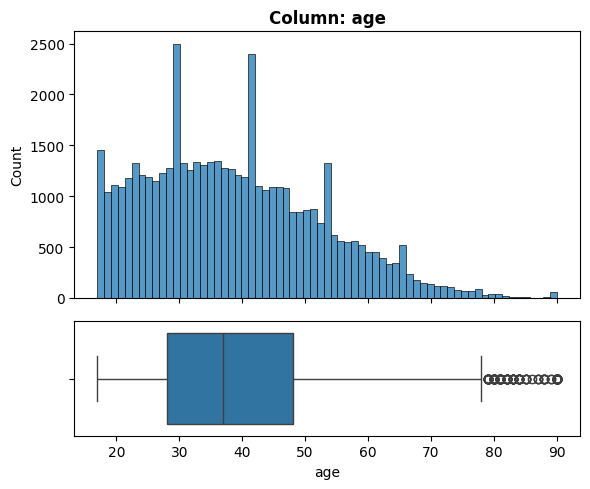

- NaN's Found: 0 (0.0%)
- Unique Values: 74
- Most common value: '36' occurs 1348 times (2.76%)
- Not constant or quasi-constant.


In [ ]:
#age
explore_numeric(df, 'age')
warnings.filterwarnings('ignore')

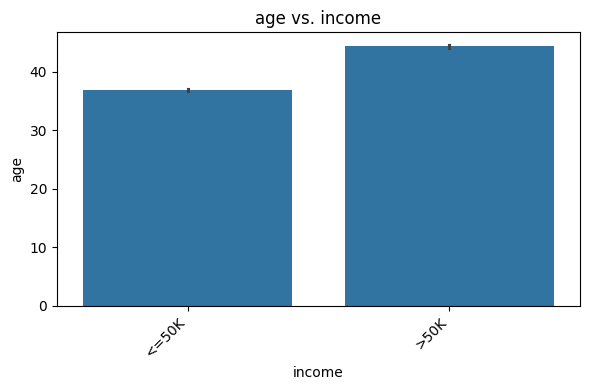

In [ ]:
plot_numeric_vs_target(df, x = 'age', y = 'income', target_type='class')
warnings.filterwarnings('ignore')

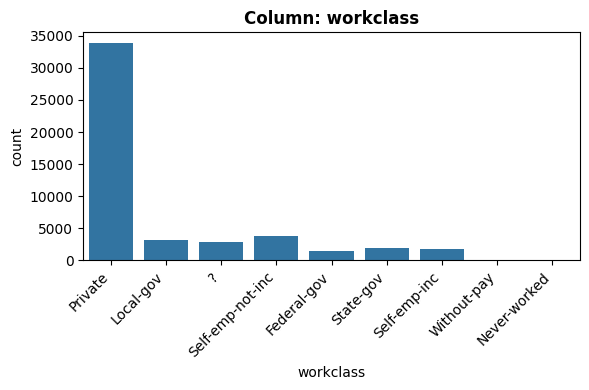

- NaN's Found: 0 (0.0%)
- Unique Values: 9
- Most common value: 'Private' occurs 33860 times (69.4%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, 'workclass')
warnings.filterwarnings('ignore')

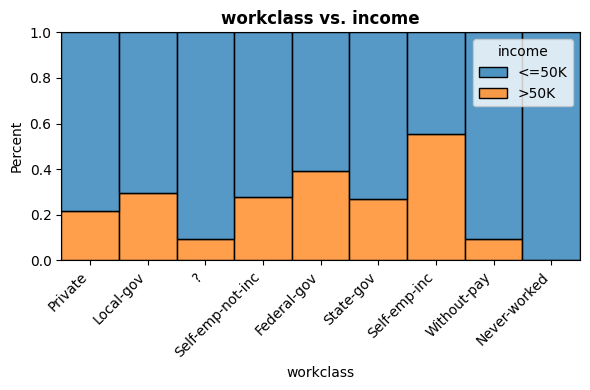

In [ ]:
plot_categorical_vs_target(df, 'workclass', y = 'income', target_type='class')
warnings.filterwarnings('ignore')

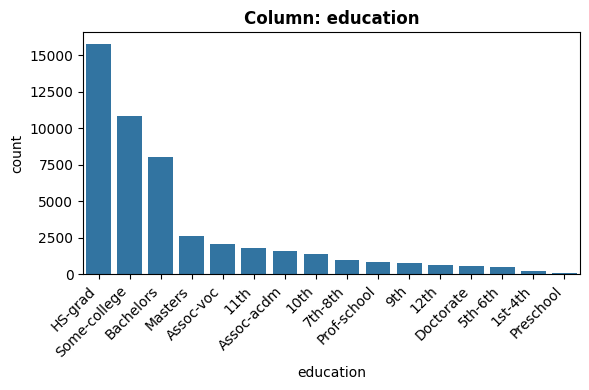

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'HS-grad' occurs 15770 times (32.32%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, 'education', order=df['education'].value_counts().index)
warnings.filterwarnings('ignore')

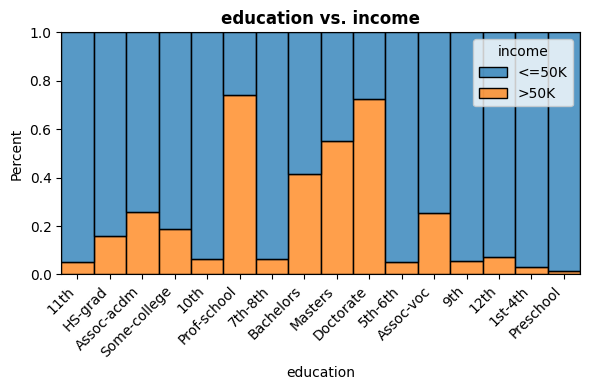

In [ ]:
plot_categorical_vs_target(df, 'education', 'income', target_type='calss')
warnings.filterwarnings('ignore')

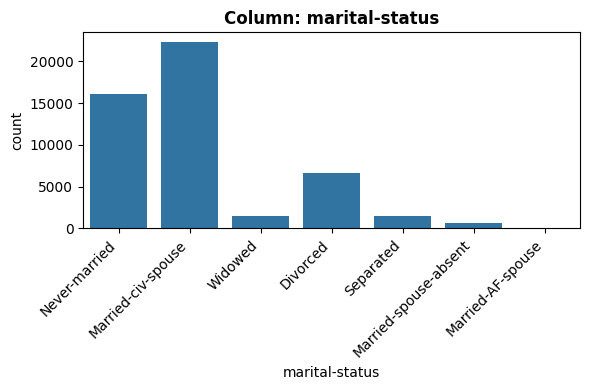

- NaN's Found: 0 (0.0%)
- Unique Values: 7
- Most common value: 'Married-civ-spouse' occurs 22366 times (45.84%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, 'marital-status')
warnings.filterwarnings('ignore')

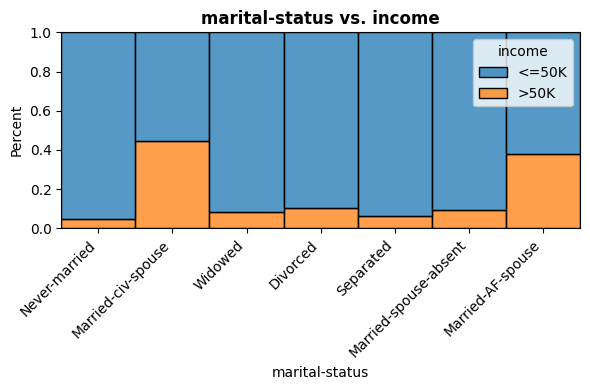

In [ ]:
plot_categorical_vs_target(df, 'marital-status', 'income', target_type='calss')
warnings.filterwarnings('ignore')

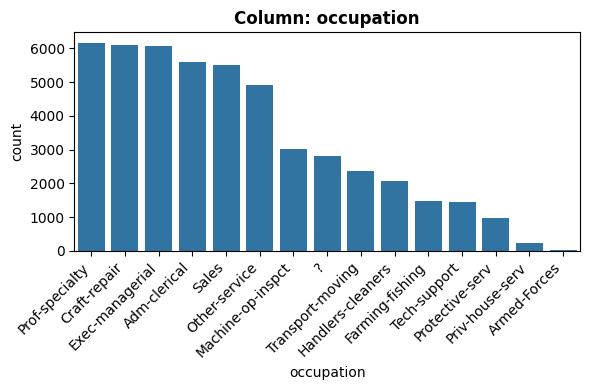

- NaN's Found: 0 (0.0%)
- Unique Values: 15
- Most common value: 'Prof-specialty' occurs 6165 times (12.64%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, 'occupation', order = df['occupation'].value_counts().index)
warnings.filterwarnings('ignore')

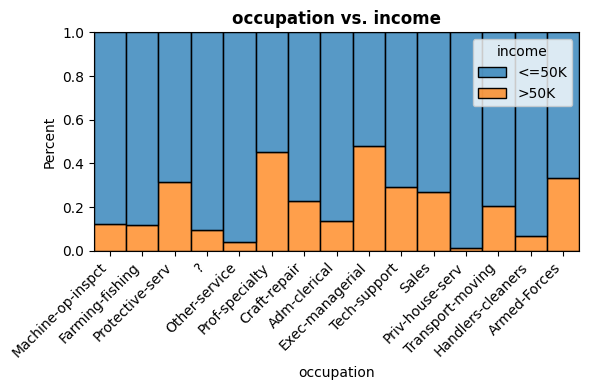

In [ ]:
plot_categorical_vs_target(df, 'occupation', 'income', target_type='calss')
warnings.filterwarnings('ignore')

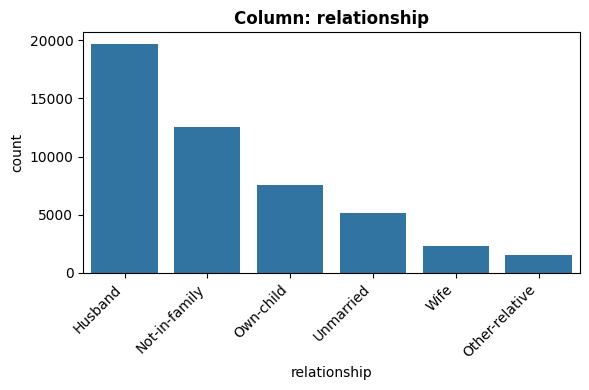

- NaN's Found: 0 (0.0%)
- Unique Values: 6
- Most common value: 'Husband' occurs 19703 times (40.38%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, 'relationship', order = df['relationship'].value_counts().index)
warnings.filterwarnings('ignore')

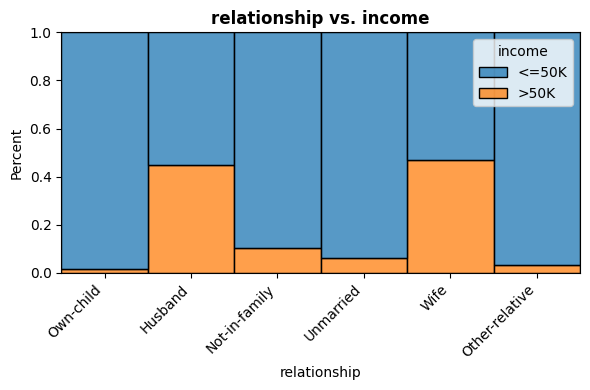

In [ ]:
plot_categorical_vs_target(df, 'relationship', 'income', target_type='calss')
warnings.filterwarnings('ignore')

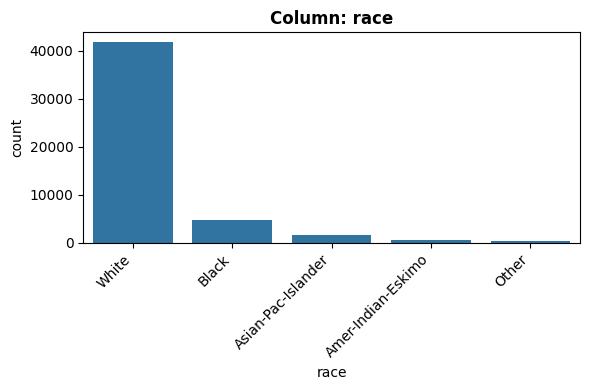

- NaN's Found: 0 (0.0%)
- Unique Values: 5
- Most common value: 'White' occurs 41714 times (85.5%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, 'race', order = df['race'].value_counts().index)
warnings.filterwarnings('ignore')

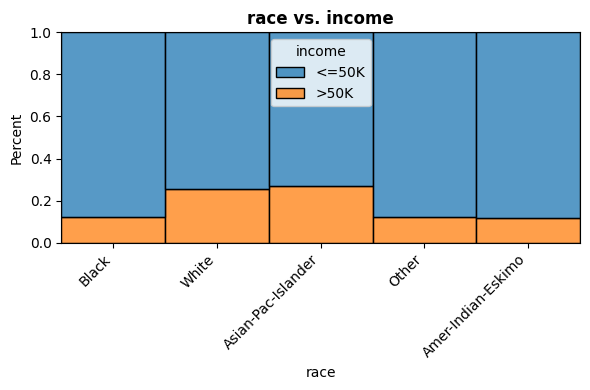

In [ ]:
plot_categorical_vs_target(df, 'race', 'income', target_type='calss')
warnings.filterwarnings('ignore')

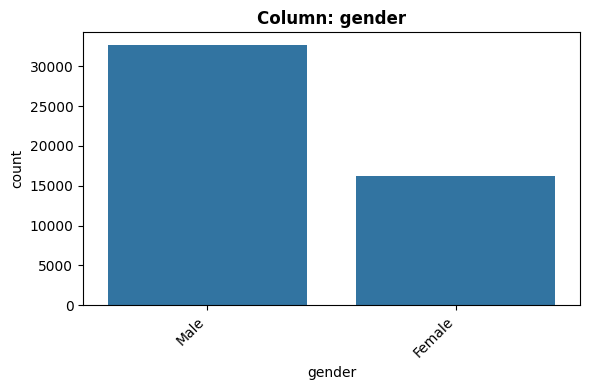

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Male' occurs 32614 times (66.85%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, 'gender', order = df['gender'].value_counts().index)
warnings.filterwarnings('ignore')

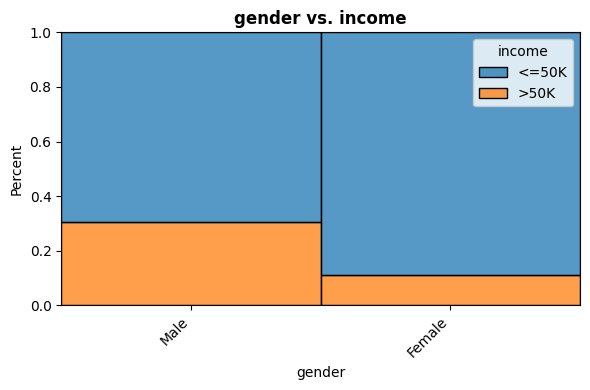

In [ ]:
plot_categorical_vs_target(df, 'gender', 'income', target_type='calss')
warnings.filterwarnings('ignore')

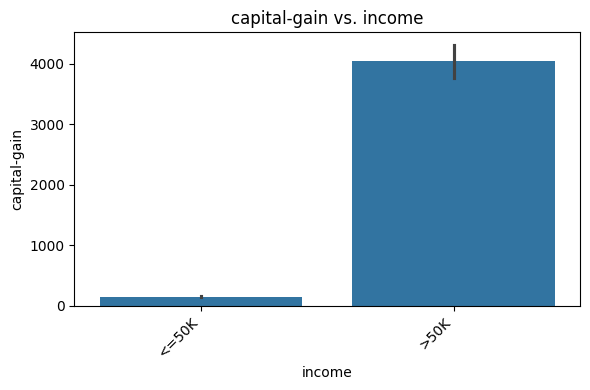

In [ ]:
plot_numeric_vs_target(df, x = 'capital-gain', y= 'income', target_type='class')
warnings.filterwarnings('ignore')

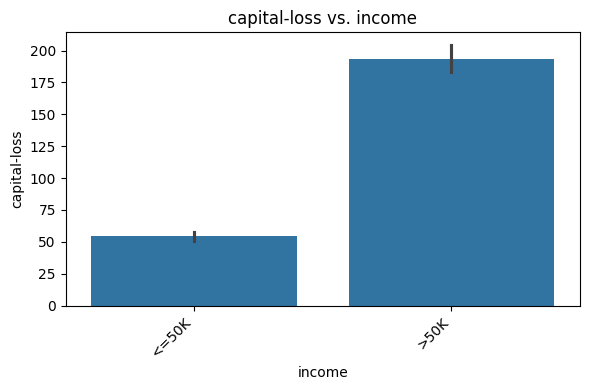

In [ ]:
plot_numeric_vs_target(df, x = 'capital-loss', y= 'income', target_type='class')
warnings.filterwarnings('ignore')

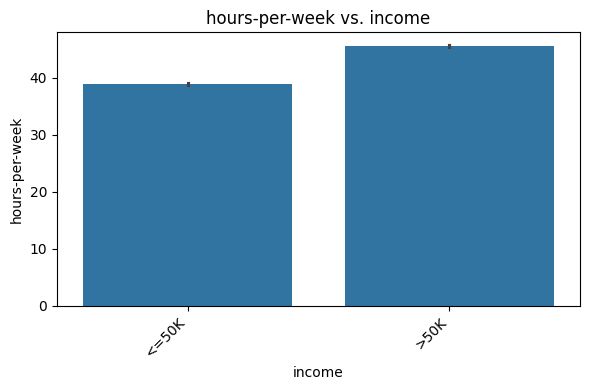

In [ ]:
plot_numeric_vs_target(df, x = 'hours-per-week', y= 'income', target_type='class')
warnings.filterwarnings('ignore')

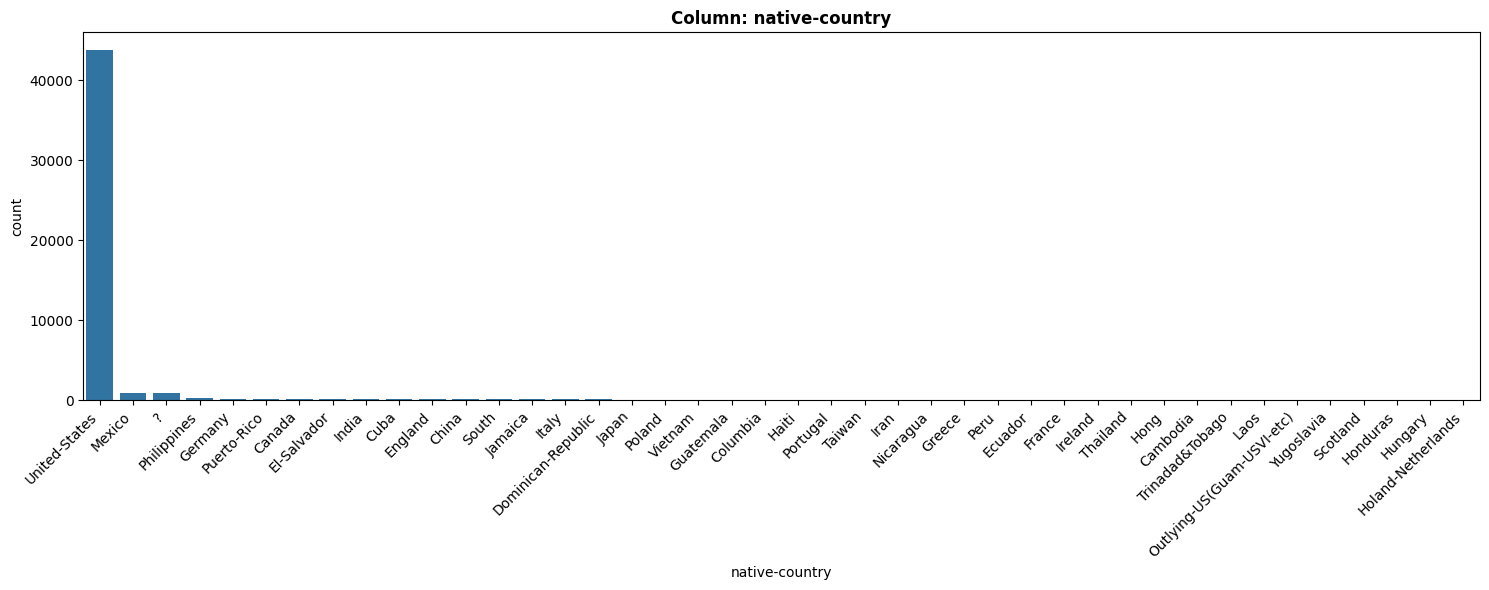

- NaN's Found: 0 (0.0%)
- Unique Values: 42
- Most common value: 'United-States' occurs 43792 times (89.76%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, 'native-country', order = df['native-country'].value_counts().index, figsize=(15, 6))
warnings.filterwarnings('ignore')

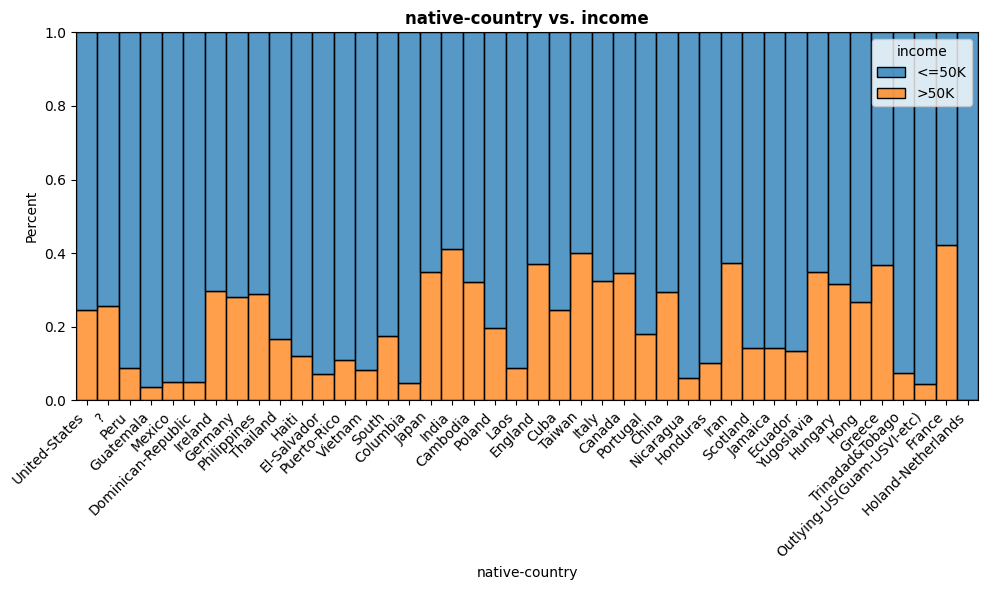

In [ ]:
plot_categorical_vs_target(df, 'native-country', 'income', target_type='calss', figsize=(10, 6))
warnings.filterwarnings('ignore')

<Axes: >

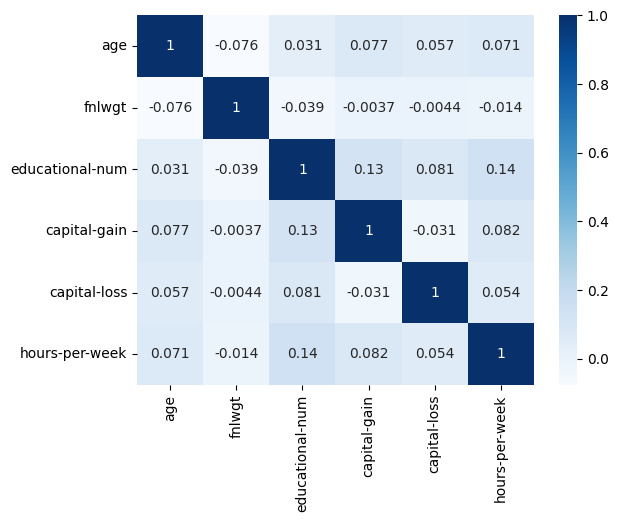

In [ ]:
sns.heatmap(df.corr(numeric_only=True), cmap='Blues', annot=True)

# Prepare the Data for Modeling

### Handling Missing '?' values

- The ratio of missing (‘?’) values is 1.6% in native-country, 5.8% in occupation, and 5.8% in workclass.

- Although these proportions are relatively low, it’s preferable not to drop the affected records, as doing so may lead to unnecessary data loss.

- Instead, I would impute the missing values using the mode of each respective column to preserve data completeness and consistency.

In [ ]:
#replace ? with nan
cols_with_missing_values = ['native-country', 'occupation', 'workclass']
for col in cols_with_missing_values:
  df[col].replace({'?': np.nan}, inplace=True)

<Axes: >

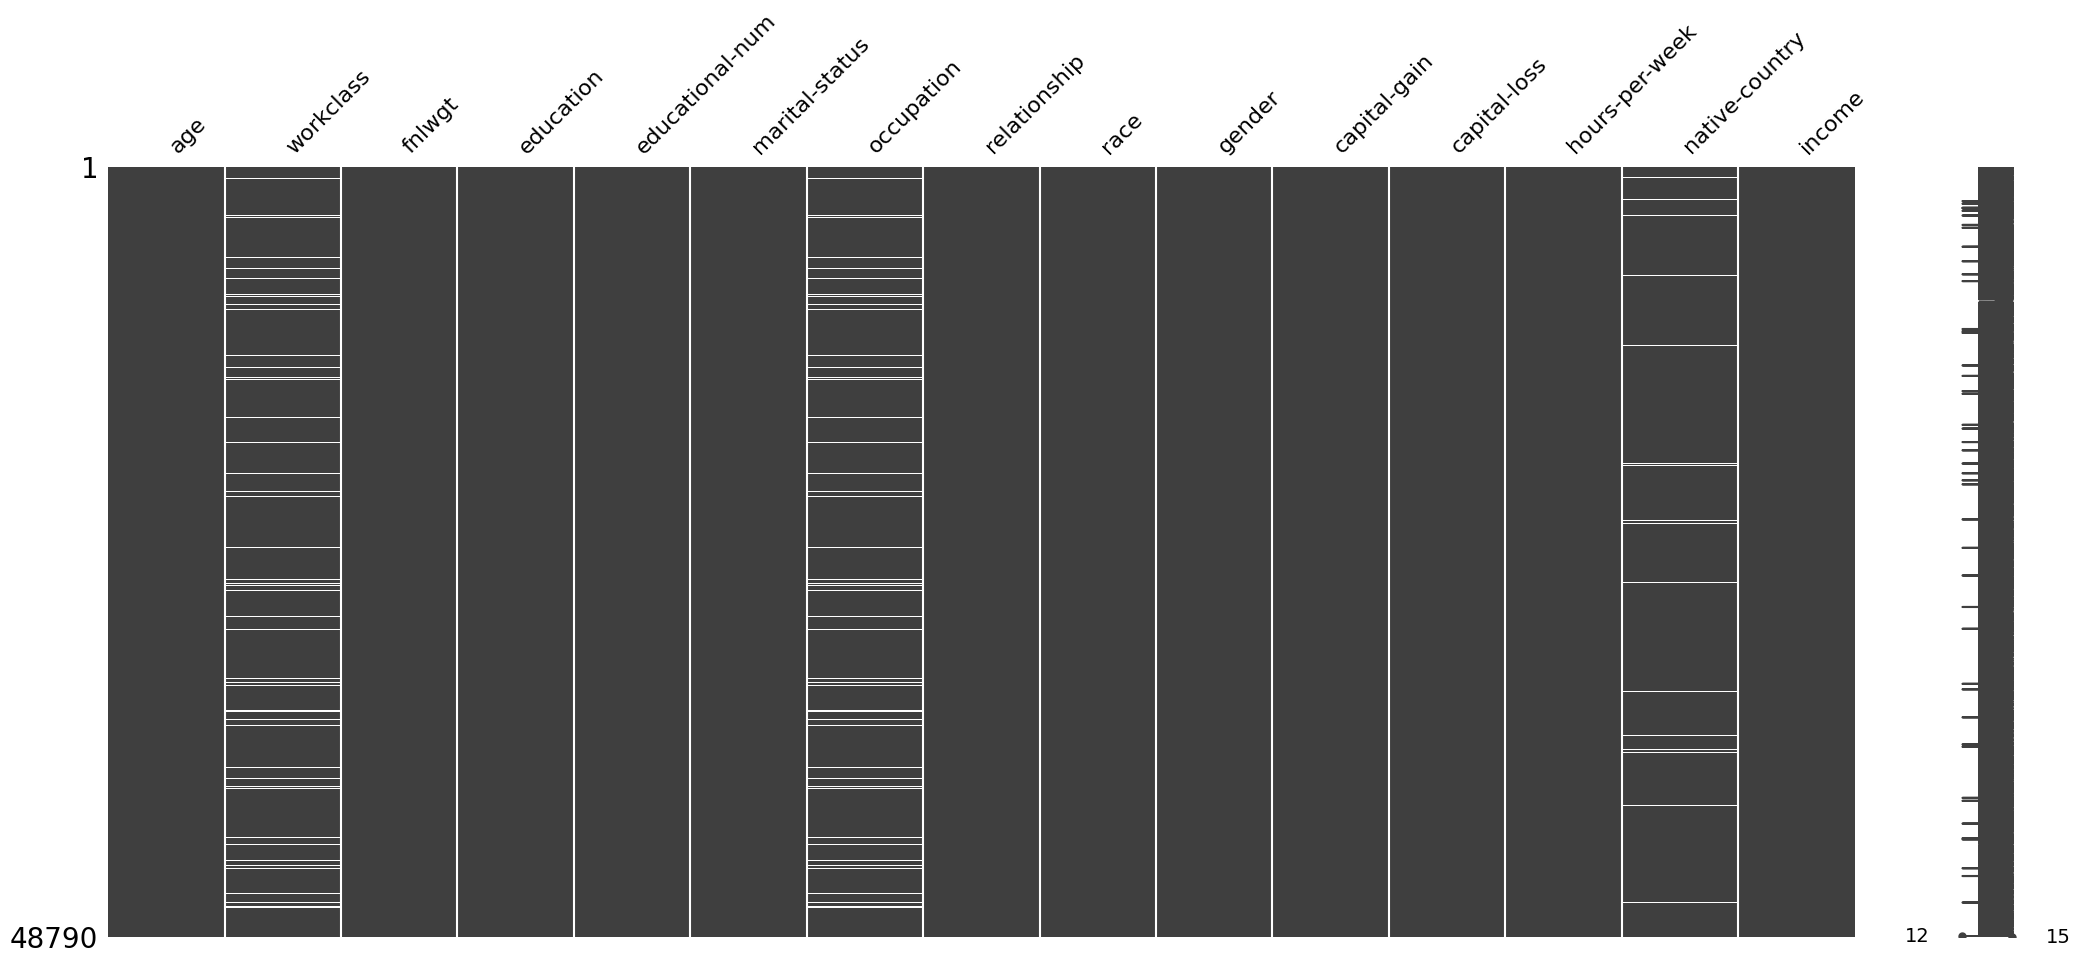

In [ ]:
#check the missing values
import missingno as msno
msno.matrix(df)

### Features for dimentionality reduction or feature selection

- Education and eductional-num are identical features each with 16 unique values -> drop education
- fnlwgt: is considered a sampling weight rather than a feature with direct predictive power for an individual's income level -> drop fnlwgt

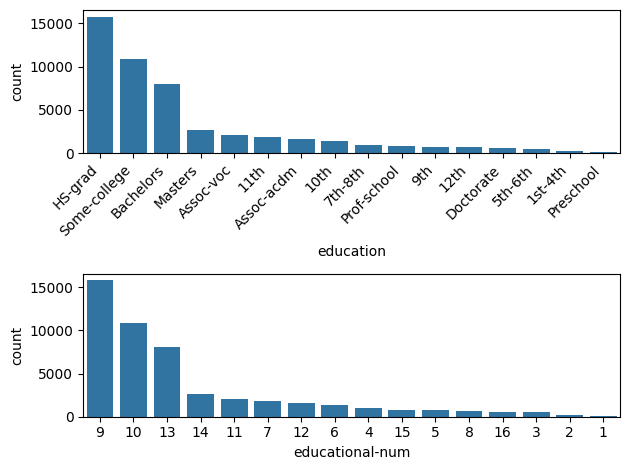

In [ ]:
#check the features' duplication through visualization
fig, ax = plt.subplots(2, 1)
sns.countplot(data = df, x = 'education' ,ax= ax[0], order=df['education'].value_counts().index)
sns.countplot(data = df, x = 'educational-num', ax = ax[1], order = df['educational-num'].value_counts().index)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation = 45, ha = 'right')
warnings.filterwarnings('ignore')
fig.tight_layout()

### Split the Data

In [ ]:
df['income'].value_counts()

,count
income,
<=50K,37109
>50K,11681


In [ ]:
# define the features matrix and the target vector
features_to_drop = ['education', 'fnlwgt', 'income']
X = df.drop(columns=[*features_to_drop])
y = df['income'].replace({'<=50K': 0,
                          '>50K' : 1})

In [ ]:

X_train,X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
y_train.value_counts()

,count
income,
0,27841
1,8751


- Dataset imbalanced, used SMOTE to oversample the minority class

### Prepocessing

In [ ]:
#numeric features
num_cols = X_train.select_dtypes('number').columns
scaler = StandardScaler()
num_tuple = ('numeric', scaler, num_cols)

In [ ]:
#categorical features
cat_cols = X_train.select_dtypes('object').columns
imputer = SimpleImputer(strategy='most_frequent')
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_pipe = make_pipeline(imputer, ohe_encoder)
cat_tuple = ('nominal', cat_pipe, cat_cols)

# Modeling

In [493]:
#Without Pipeline
"""
#instantiate the preprocessor
preprocessor = ColumnTransformer([num_tuple, cat_tuple])

#instantiate the oversampler
smote = SMOTE()

#instantiate the model
lgReg = LogisticRegression(random_state=42)

#fit the tranformer
X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)

#fit the oversampler
X_train_sm, y_train_sm = smote.fit_resample(X_train_tf, y_train)

#fit the model
lgReg.fit(X_train_sm, y_train_sm)

LogisticRegression(random_state=42)

In [494]:
# With Pipeline

#instantiate the preprocessor
preprocessor = ColumnTransformer([num_tuple, cat_tuple])

#instantiate the oversampler
smote = SMOTE(random_state=42)

#instantiate the model
lgReg = LogisticRegression(random_state=42)

#instantiate sampler pipeline
log_reg_pipe = Pipeline([
    ('preprocessor', ColumnTransformer([num_tuple, cat_tuple])),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(random_state=42))
])

#fit the pipeline
log_reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  Index(['age', 'educational-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')),
                                                 ('nominal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['workclass', 'marital-status', 'occupation', 'relationship', 'race',
       'gender', 'native-country'],
      dtype='object'))])),
                ('smote', SMOTE(random_state=42)),
                ('model', LogisticRegression(random_state=42))])

## Evaluation

----------------------------------------------------------------------
Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.86     27841
           1       0.57      0.85      0.68      8751

    accuracy                           0.81     36592
   macro avg       0.76      0.82      0.77     36592
weighted avg       0.85      0.81      0.82     36592



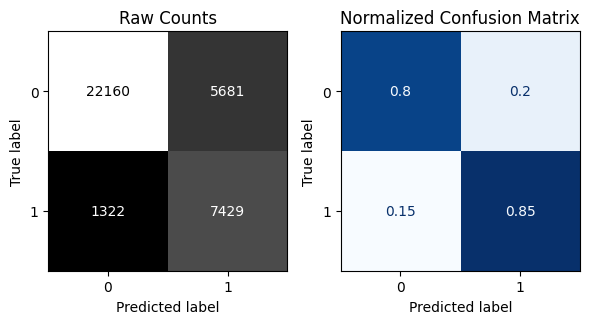

----------------------------------------------------------------------
Classification Metrics: Testing Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      9268
           1       0.57      0.84      0.68      2930

    accuracy                           0.81     12198
   macro avg       0.75      0.82      0.77     12198
weighted avg       0.85      0.81      0.82     12198



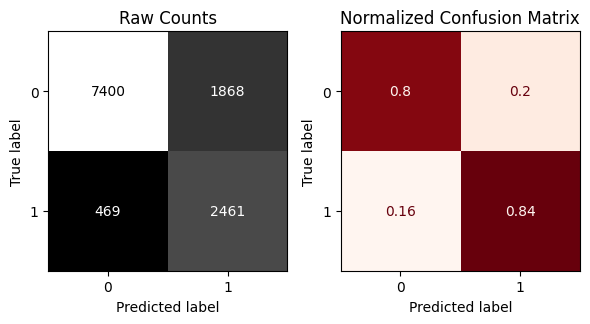

In [495]:
#with pipeline
evaluate_classification(log_reg_pipe, X_train, y_train, X_test, y_test)

#without pipeline
#evaluate_classification(lgReg, X_train_sm, y_train_sm, X_test_tf, y_test)

## Model Insights using Permutation Importance

In [ ]:
r = permutation_importance(lgReg, X_test_tf, y_test, n_repeats=5, random_state=42)

In [ ]:
permutation_importances = pd.DataFrame({'Features_Names': X_test_tf.columns,
              'Permutation_Importance': r.importances_mean}).sort_values(by = 'Permutation_Importance', ascending=False).head(10)


In [ ]:
permutation_importances

,Features_Names,Permutation_Importance
15,nominal__marital-status_Married-civ-spouse,0.031481
1,numeric__educational-num,0.027578
2,numeric__capital-gain,0.022118
34,nominal__relationship_Husband,0.006854
23,nominal__occupation_Exec-managerial,0.003656
29,nominal__occupation_Prof-specialty,0.002312
35,nominal__relationship_Not-in-family,0.002295
46,nominal__gender_Male,0.002148
10,nominal__workclass_Self-emp-not-inc,0.001574
3,numeric__capital-loss,0.001492


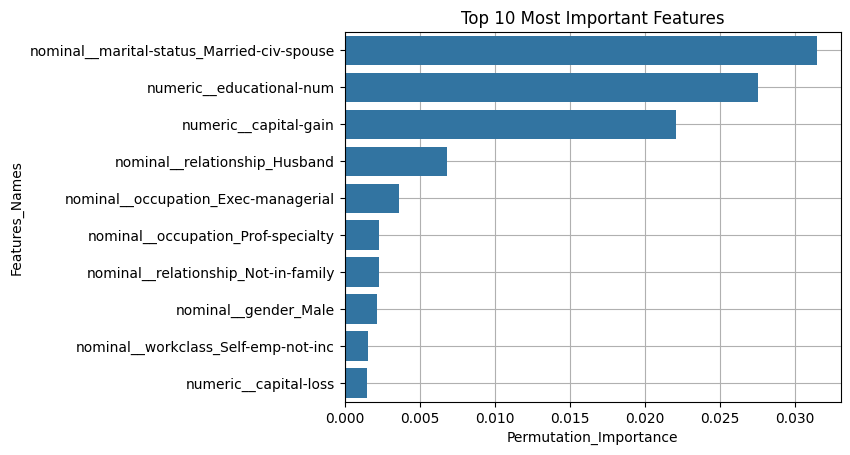

In [ ]:
ax = sns.barplot(data =permutation_importances, x = 'Permutation_Importance', y = 'Features_Names', zorder = 2)
ax.set_title('Top 10 Most Important Features')
ax.grid(zorder = 0)
warnings.filterwarnings('ignore')

- The prediction task is to determine the income of adults, and the four most important features based on the permutation importance are **marital_status, education, capital-gain and occupation** respectively, which make perfect sense as predictors of income and align with real-world **socioeconomic patterns**
  - Education/Occupation -> determine job opportunities which drive income
  - Marital/relationship status -> stability and combined income
  - Capital-gain/loss -> high-income individuals have more assets/investments.
  Workclass/hours-per-week -> private/self-employed/public and working time directly affect income.

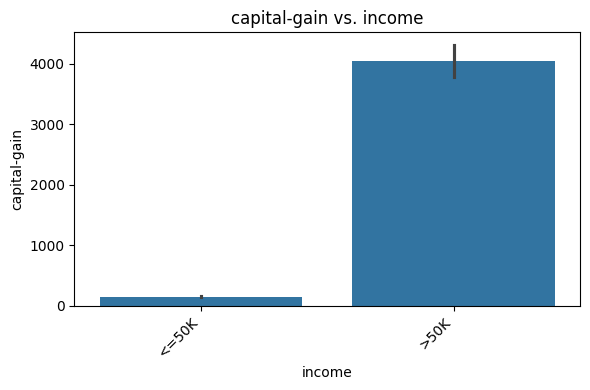

In [ ]:
plot_numeric_vs_target(df, x = 'capital-gain', y= 'income', target_type='class')
warnings.filterwarnings('ignore')

- The chart shows that the average capital gain for individuals earning more than 50K is around 4000, which is significantly higher than the average of only 200 for those earning 50K or less.
This indicates that higher-income individuals tend to have substantially greater investment returns or asset-related income compared to lower-income earners.

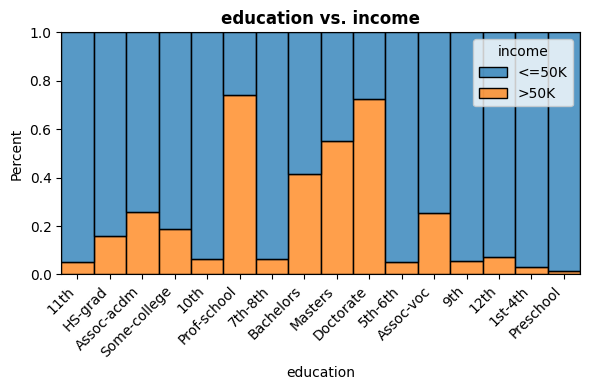

In [ ]:
fig, ax = plot_categorical_vs_target(df, 'education', 'income', target_type='calss')
warnings.filterwarnings('ignore')

- we can clearly see a strong positive relationship between education level and income level
  - Individuals with higher education degrees (such as Bachelors, Masters, and Doctorate) show a much higher proportion of people earning more than 50K.
  - People with lower education levels (such as 9th–12th grade, some college, high school graduate, or below) are in the <=50K income group.

# Modeling with PCA

In [ ]:
#instantiate the pca with 3 components
pca = PCA(n_components=3)

#fit and transform with pca
X_train_pca = pca.fit_transform(X_train_sm)
X_test_pca  = pca.transform(X_test_tf)

#instantiate the model
lgReg_pca = LogisticRegression(random_state=42)

#fit the model on pca training
lgReg_pca.fit(X_train_pca, y_train_sm)

LogisticRegression(random_state=42)

## Evaluation

----------------------------------------------------------------------
Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     27841
           1       0.79      0.79      0.79     27841

    accuracy                           0.79     55682
   macro avg       0.79      0.79      0.79     55682
weighted avg       0.79      0.79      0.79     55682



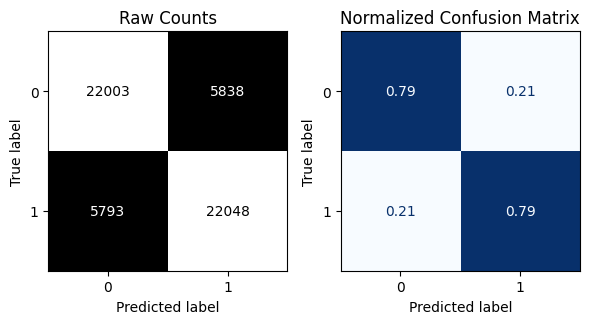

----------------------------------------------------------------------
Classification Metrics: Testing Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.79      0.85      9268
           1       0.54      0.78      0.64      2930

    accuracy                           0.79     12198
   macro avg       0.73      0.79      0.75     12198
weighted avg       0.83      0.79      0.80     12198



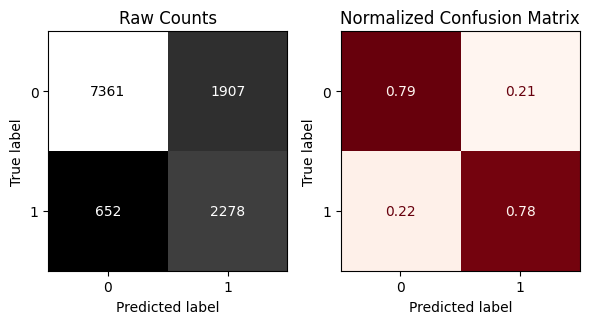

In [ ]:
evaluate_classification(lgReg_pca, X_train_pca, y_train_sm, X_test_pca, y_test)

# Modeling with Clustering

In [496]:
X_train_tf = preprocessor.fit_transform(X_train)
X_test_tf = preprocessor.transform(X_test)

In [498]:

inertia = []
silh = []
for k in range(2, 11):
  kmeans = KMeans(n_clusters=k, n_init='auto', random_state=42)
  kmeans.fit(X_train_tf)
  inertia.append(kmeans.inertia_)
  silh.append(silhouette_score(X_train_tf, kmeans.labels_))



Text(0.5, 1.0, 'Silhouette Scores')

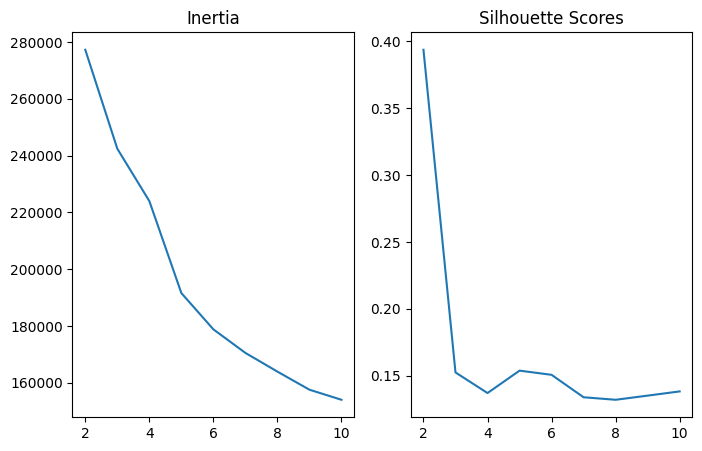

In [499]:

fig, ax = plt.subplots(1, 2, figsize = (8,5))
sns.lineplot(x = range(2, 11), y = inertia, ax = ax[0])
sns.lineplot(x = range(2, 11), y = silh, ax = ax[1])
ax[0].set_title('Inertia')
ax[1].set_title('Silhouette Scores')


- Modeling with 3 label clustering

In [500]:
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)
kmeans.fit(X_train_tf)

KMeans(n_clusters=3, random_state=42)

In [ ]:
#add cluster labels to training and testing
X_train_clustered = X_train_tf
X_train_clustered[f'cluster{kmeans.n_clusters}'] = kmeans.predict(X_train_tf)
X_test_clustered = X_test_tf
X_test_clustered[f'cluster{kmeans.n_clusters}'] = kmeans.predict(X_test_tf)

In [ ]:
#scaling after adding the cluster labels
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clustered)
X_test_scaled = scaler.transform(X_test_clustered)

In [ ]:
#oversampling the training data
X_train_clustered_sm, y_train_clustered_sm = smote.fit_resample(X_train_scaled, y_train)

In [ ]:
lgReg_cluster = LogisticRegression(random_state=42)
#modeling
lgReg_cluster.fit(X_train_clustered_sm,y_train_clustered_sm)

LogisticRegression(random_state=42)

----------------------------------------------------------------------
Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.79      0.82     27841
           1       0.81      0.86      0.83     27841

    accuracy                           0.83     55682
   macro avg       0.83      0.83      0.83     55682
weighted avg       0.83      0.83      0.83     55682



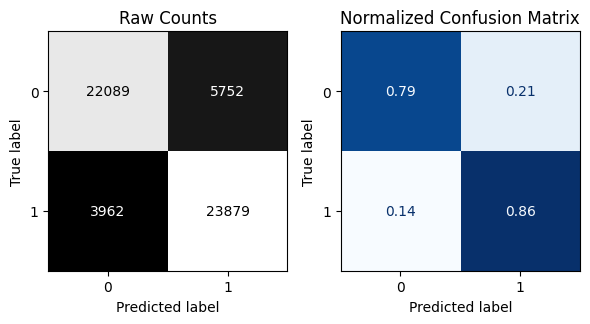

----------------------------------------------------------------------
Classification Metrics: Testing Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.80      0.86      9268
           1       0.57      0.85      0.68      2930

    accuracy                           0.81     12198
   macro avg       0.76      0.82      0.77     12198
weighted avg       0.85      0.81      0.82     12198



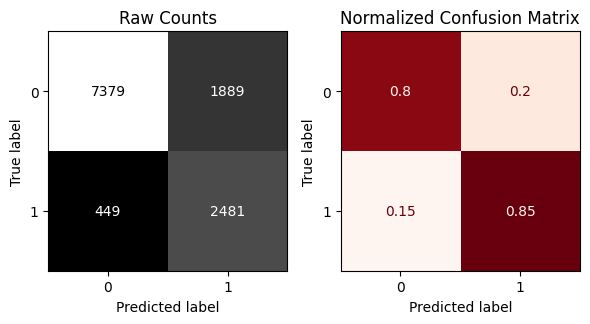

In [ ]:
evaluate_classification(lgReg_cluster, X_train_clustered_sm, y_train_clustered_sm, X_test_scaled, y_test)

#Feature Selection

## Correlation Filter Method

<Axes: >

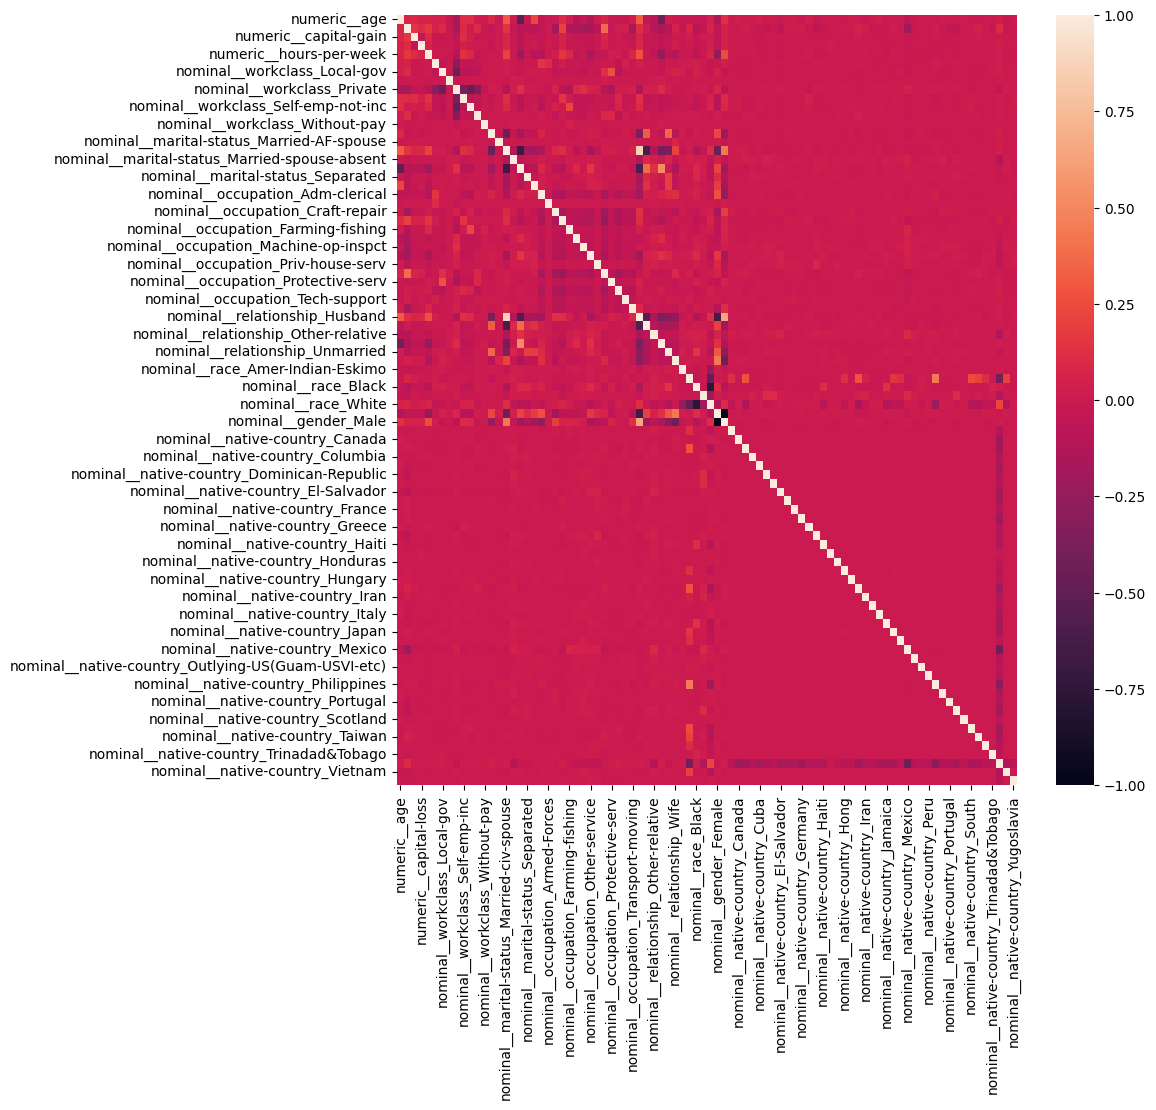

In [ ]:
#correlation heatmap with all features
corr  = X_train_sm.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(X_train_sm.corr())

- We have a small set of correlated features

In [ ]:
# import the collinearity selector and suitable scoring metric
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif # f_regression for regression task

#instantiate the selector
selector = SelectNonCollinear(correlation_threshold= 0.75, scoring = f_classif)

#fit selector on trainig data
selector.fit(X_train_sm.values, y_train_sm.values) # we need to include the target to help the selector prioritize the most important features for the target


In [ ]:
#how many features we will drop
selector.get_support().count(False) # above the threshold

3

In [ ]:
non_collinear_series = pd.Series(selector.get_support(), index = X_train_sm.columns)
non_collinear_series

,0
numeric__age,True
numeric__educational-num,True
numeric__capital-gain,True
numeric__capital-loss,True
numeric__hours-per-week,True
...,...
nominal__native-country_Thailand,True
nominal__native-country_Trinadad&Tobago,True
nominal__native-country_United-States,True
nominal__native-country_Vietnam,True


In [ ]:
X_train_no_corr = X_train_sm.loc[:, non_collinear_series[non_collinear_series].index]
X_test_no_corr = X_test_tf.loc[:, non_collinear_series[non_collinear_series].index]

<Axes: >

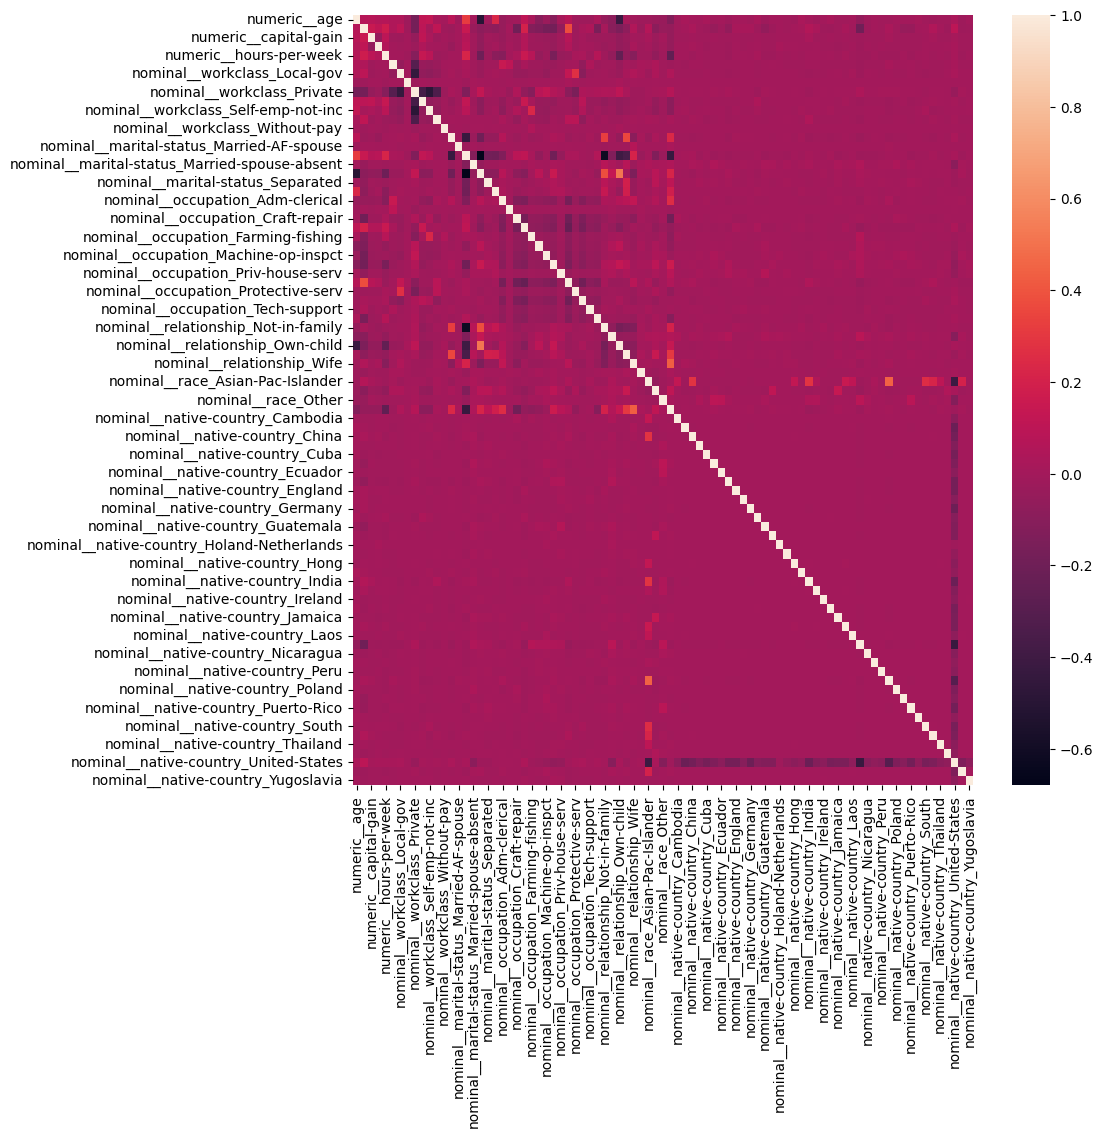

In [ ]:
#correlation heatmap for non collinear features
corr = X_train_no_corr.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr)

In [ ]:
lgReg.fit(X_train_no_corr, y_train_sm)
evaluate_classification(lgReg, X_train_no_corr, y_train_sm, X_test_no_corr, y_test)

## Model Insights using Permutation Importance

In [ ]:
r = permutation_importance(lgReg, X_test_no_corr, y_test, n_repeats=5, random_state=42)

In [ ]:
permutation_importances = pd.DataFrame({'Features_Names': X_test_no_corr.columns,
              'Permutation_Importance': r.importances_mean}).sort_values(by = 'Permutation_Importance', ascending=False).head(10)


In [ ]:
permutation_importances

,Features_Names,Permutation_Importance
15,nominal__marital-status_Married-civ-spouse,0.028234
1,numeric__educational-num,0.027119
2,numeric__capital-gain,0.021987
34,nominal__relationship_Not-in-family,0.005837
23,nominal__occupation_Exec-managerial,0.003394
37,nominal__relationship_Unmarried,0.002705
29,nominal__occupation_Prof-specialty,0.002082
10,nominal__workclass_Self-emp-not-inc,0.001935
38,nominal__relationship_Wife,0.001394
3,numeric__capital-loss,0.001377


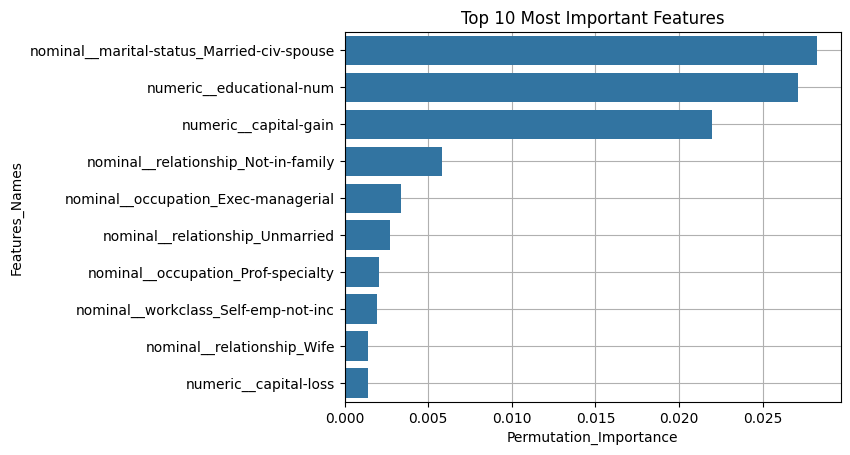

In [485]:
ax = sns.barplot(data =permutation_importances, x = 'Permutation_Importance', y = 'Features_Names', zorder = 2)
ax.set_title('Top 10 Most Important Features')
ax.grid(zorder = 0)
warnings.filterwarnings('ignore')

In [487]:
df.values

array([[25, 'Private', 226802, ..., 40, 'United-States', '<=50K'],
       [38, 'Private', 89814, ..., 50, 'United-States', '<=50K'],
       [28, 'Local-gov', 336951, ..., 40, 'United-States', '>50K'],
       ...,
       [58, 'Private', 151910, ..., 40, 'United-States', '<=50K'],
       [22, 'Private', 201490, ..., 20, 'United-States', '<=50K'],
       [52, 'Self-emp-inc', 287927, ..., 40, 'United-States', '>50K']],
      dtype=object)